# Parte 2: Programando LSTM with Keras and TensorFlow

Las redes neuronales multicapas solo tienen conexiones directas. Las redes neuronales de este tipo siempre comienzan con una capa de entrada conectada a la primera capa oculta. Cada capa oculta siempre se conecta a la siguiente capa oculta. La última capa oculta siempre se conecta a la capa de salida. Esta forma de conectar capas es la razón por la que estas redes se denominan "feedforward". Las redes neuronales recurrentes no son tan rígidas, ya que también se permiten conexiones hacia atrás. Una conexión recurrente vincula una neurona en una capa con una capa anterior o con la neurona misma. La mayoría de las arquitecturas de redes neuronales recurrentes mantienen el estado de las conexiones recurrentes. Las redes neuronales feedforward no mantienen ningún estado. El estado de una red neuronal recurrente actúa como una especie de memoria a corto plazo para la red neuronal. En consecuencia, una red neuronal recurrente no siempre producirá la misma salida para una entrada determinada.

Las redes neuronales recurrentes solamente se limitan pasar información de una capa a la siguient. Una conexión recurrente ocurre cuando se forma una conexión entre una neurona y uno de los siguientes tipos de neuronas:

* La neurona misma
* Una neurona al mismo nivel
* Una neurona en un nivel anterior

Las conexiones recurrentes nunca pueden apuntar a las neuronas de entrada ni a las neuronas de bias.
El procesamiento de conexiones recurrentes puede resultar complicado. Debido a que los enlaces recurrentes crean bucles infinitos, la red neuronal debe tener alguna forma de saber cuándo detenerse. Una red neuronal que entrara en un bucle sin fin no sería útil. Para evitar bucles sin fin, podemos calcular las conexiones recurrentes con los siguientes tres enfoques:

* Neuronas de contexto
* Cálculo de la salida sobre un número fijo de iteraciones
* Calculando la salida hasta que la salida de la neurona se estabilice

La neurona de contexto es un tipo de neurona especial que recuerda su entrada y proporciona esa entrada como salida la próxima vez que calculemos la red. Por ejemplo, si le damos a una neurona de contexto 0.5 como entrada, generará 0. Las neuronas de contexto siempre generan 0 en su primera llamada. Sin embargo, si le damos a la neurona de contexto un 0.6 como entrada, la salida sería 0.5. Nunca sopesamos las conexiones de entrada a una neurona de contexto, pero podemos sopesar la salida de una neurona de contexto como cualquier otra conexión de red.

Las neuronas de contexto nos permiten calcular una red neuronal en una sola pasada de retroalimentación. Las neuronas de contexto suelen presentarse en capas. Una capa de neuronas de contexto siempre tendrá el mismo número de neuronas de contexto que neuronas en su capa de origen, como se demuestra en la Figura 1.

** Figura 1. Capas de contexto **
![Context Layers](../images/class_10_context_layer.png "Context Layers")

Como se puede ver en la capa anterior, dos neuronas ocultas que están etiquetadas como una oculta y dos ocultas se conectan directamente a las dos neuronas de contexto. Las líneas discontinuas en estas conexiones indican que no son conexiones ponderadas. Estas conexiones nunca son densas. Si estas conexiones fueran densas, una oculta estaría conectada tanto a la oculta como a la oculta 2. Sin embargo, la conexión directa une cada neurona oculta a su neurona de contexto correspondiente. Las dos neuronas de contexto forman conexiones densas y ponderadas con las dos neuronas ocultas. Finalmente, las dos neuronas ocultas también forman densas conexiones con las neuronas de la siguiente capa. Las dos neuronas de contexto forman dos conexiones con una sola neurona en la siguiente capa, cuatro conexiones con dos neuronas, seis conexiones con tres neuronas, y así sucesivamente.

Puede combinar neuronas de contexto con las capas de entrada, ocultas y de salida de una red neuronal de muchas formas diferentes.
Enviar comentarios
Historial
Guardadas
Comunidad

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Entendiendo las redes LSTM

Las capas de una red neuronal  (LSTM) son un tipo de unidad recurrente que se utiliza a menudo con redes neuronales profundas.[[Cite:hochreiter1997long]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320) 
a TensorFlow, puede pensar en LSTM como un tipo de capa que puede combinar con otros tipos de capas, como densa. LSTM hace uso de dos tipos de funciones de transferencia internamente.

$ \mbox{S}(t) = \frac{1}{1 + e^{-t}} $

El segundo tipo de función de transferencia es la función de tangente hiperbólica (tanh), que puede escalar la salida del LSTM. Esta funcionalidad es similar a cómo hemos utilizado otras funciones de transferencia en este curso.

Proporcionamos los gráficos para estas funciones aquí:

Sigmoid


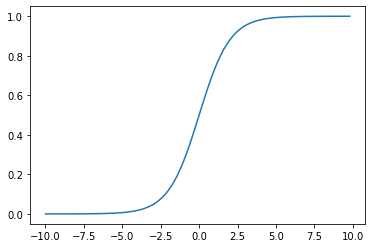

(tanh)


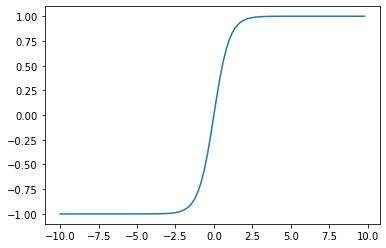

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

def f2(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
y1 = sigmoid(x)
y2 = f2(x)

print("Sigmoid")
plt.plot(x,y1)
plt.show()

print("(tanh)")
plt.plot(x,y2)
plt.show()

Ambas funciones comprimen la salida a un rango específico. Para la función sigmoide, este rango es de 0 a 1. Para la función tangente hiperbólica, este rango es de -1 a 1.

LSTM mantiene un estado interno y produce una salida. El siguiente diagrama muestra una unidad LSTM en tres segmentos de tiempo: el segmento de tiempo actual (t), así como el segmento anterior (t-1) y el siguiente (t + 1), como se muestra en la Figura 2.


**Figure 2.Capas LSTM**
![LSTM Layers](../images/class_10_lstm1.png "LSTM Layers")

Los valores $\hat{y}$ son la salida; los valores ($x$) son las entradas, y los valores $c$ son el contexto.  203/5000
Los valores de salida y contexto siempre alimentan su salida al siguiente segmento de tiempo. Los valores de contexto permiten que la red mantenga el estado entre llamadas. Figura 3 muestra los componentes internos de una capa de LSTM.

**Figure 3: Interior de una capa LSTM**
![LSTM Layers](../images/class_10_lstm2.png "Inside the LSTM")

Una unidad LSTM consta de tres puertas:

* Forget Gate ($f_t$) - Controla cuando se olvida el contexto. (MC)
* Input Gate ($i_t$) - Controla cuando el contexto debe recordar un valor. (M+/MS)
* Output Gate ($o_t$) - Controla cuándo se permite que el valor recordado pase de la unidad. (RM)

Matemáticamente, puede pensar en el diagrama anterior como el siguiente:

** Estos son valores vectoriales. **

Primero, calcule el valor de la forget. Esta puerta determina si la unidad LSTM debe olvidar su memoria a corto plazo. El valor $ b $ es un bias, al igual que las neuronas de bias que vimos antes. Excepto que LSTM tiene un sesgo para cada puerta: $ b_t $, $ b_i $ y $ b_o $.
$ f_t = S(W_f \cdot [\hat{y}_{t-1}, x_t] + b_f) $

$ i_t = S(W_i \cdot [\hat{y}_{t-1},x_t] + b_i) $

$ \tilde{C}_t = \tanh(W_C \cdot [\hat{y}_{t-1},x_t]+b_C) $

$ C_t = f_t \cdot C_{t-1}+i_t \cdot \tilde{C}_t $

$ o_t = S(W_o \cdot [\hat{y}_{t-1},x_t] + b_o ) $

$ \hat{y}_t = o_t \cdot \tanh(C_t) $


# Ejemplo Simple en  TensorFlow 

El siguiente código crea la red LSTM, que es un ejemplo de un RNN para clasificación. El siguiente código se entrena en un conjunto de datos (x) con un tamaño máximo de secuencia de 6 (columnas) y seis elementos de entrenamiento (filas)

In [5]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
import numpy as np

max_features = 4 # 0,1,2,3 (total of 4)
x = [
    [[0],[1],[1],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[0],[3],[3]],
    [[0],[2],[2],[0],[0],[0]],
    [[0],[0],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]]
]
x = np.array(x,dtype=np.float32)
y = np.array([1,2,3,2,3,1],dtype=np.int32)

# Convert y2 to dummy variables
y2 = np.zeros((y.shape[0], max_features),dtype=np.float32)
y2[np.arange(y.shape[0]), y] = 1.0
print(y2)

print('Construir el modelo...')
model = Sequential()
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, \
               input_shape=(None, 1)))
model.add(Dense(4, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x,y2,epochs=200)
pred = model.predict(x)
predict_classes = np.argmax(pred,axis=1)
print("Predicted classes: {}",predict_classes)
print("Expected classes: {}",predict_classes)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
Construir el modelo...
Train...
Train on 6 samples
Epoch 1/200
6/6 [==============================] - 11s 2s/sample - loss: 0.6861 - accuracy: 0.7083
Epoch 2/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.6784 - accuracy: 0.7500
Epoch 3/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.6787 - accuracy: 0.7500
Epoch 4/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.6774 - accuracy: 0.7500
Epoch 5/200
6/6 [==============================] - 0s 8ms/sample - loss: 0.6680 - accuracy: 0.7500
Epoch 6/200
6/6 [==============================] - 0s 5ms/sample - loss: 0.6490 - accuracy: 0.7500
Epoch 7/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.6593 - accuracy: 0.7500
Epoch 8/200
6/6 [==============================] - 0s 8ms/sample - loss: 0.6293 - accuracy: 0.7500
Epoch 9/200
6/6 [==============================] - 0s 8ms/sample -

In [6]:
def runit(model, inp):
    inp = np.array(inp,dtype=np.float32)
    pred = model.predict(inp)
    return np.argmax(pred[0])

print( runit( model, [[[0],[0],[0],[0],[0],[1]]] ))


1


In [7]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15193452248967720763
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1401988300
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15961410948227089699
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Ejemplos de los ciclos solares
En esta sección, vemos un ejemplo de regresión RNN para predecir manchas solares. Puede encontrar los archivos de datos necesarios para este ejemplo en la siguiente ubicación.

* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

El siguiente código carga el archivo de manchas solares:

In [9]:
import pandas as pd
import os

PATH = "../data/"
    
filename = os.path.join(PATH,"SN_d_tot_V2.0.csv")    
names = ['year', 'month', 'day', 'dec_year', 'sn_value' , 
         'sn_error', 'obs_num']
df = pd.read_csv(filename,sep=';',header=None,names=names,
                 na_values=['-1'], index_col=False)

print("Inicio :")
print(df[0:10])

print("Fin:")
print(df[-10:])

Inicio :
   year  month  day  dec_year  sn_value  sn_error  obs_num
0  1818      1    1  1818.001        -1       NaN        0
1  1818      1    2  1818.004        -1       NaN        0
2  1818      1    3  1818.007        -1       NaN        0
3  1818      1    4  1818.010        -1       NaN        0
4  1818      1    5  1818.012        -1       NaN        0
5  1818      1    6  1818.015        -1       NaN        0
6  1818      1    7  1818.018        -1       NaN        0
7  1818      1    8  1818.021        65      10.2        1
8  1818      1    9  1818.023        -1       NaN        0
9  1818      1   10  1818.026        -1       NaN        0
Fin:
       year  month  day  dec_year  sn_value  sn_error  obs_num
74074  2020     10   22  2020.807        11       1.0       34
74075  2020     10   23  2020.810        22       0.9       16
74076  2020     10   24  2020.813        21       0.8       17
74077  2020     10   25  2020.816        22       1.6        7
74078  2020     10   2

Como puede ver, faltan bastantes datos cerca del final del archivo. Queremos encontrar el índice inicial donde los datos faltantes ya no ocurren. Esta técnica es algo descuidada; sería mejor encontrar un uso para los datos entre los valores perdidos. Sin embargo, el objetivo de este ejemplo es mostrar cómo usar LSTM con una serie de tiempo algo simple.

In [10]:
start_id = max(df[df['obs_num'] == 0].index.tolist())+1  # Encontrar el primer cero
print(start_id)
df = df[start_id:] # Remover las observaciones faltantes

11314


In [11]:
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year']<2000]
df_test = df[df['year']>=2000]

spots_train = df_train['sn_value'].tolist()
spots_test = df_test['sn_value'].tolist()

print("El conjunto de entrenamiento {} observaciones.".format(len(spots_train)))
print("El conjunto de validación {} observaciones.".format(len(spots_test)))

El conjunto de entrenamiento 55160 observaciones.
El conjunto de validación 7610 observaciones.


In [13]:
import numpy as np

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Forma del conjunto de entrenamiento: {}".format(x_train.shape))
print("Forma del conjunto de validación: {}".format(x_test.shape))

Forma del conjunto de entrenamiento: (55150, 10, 1)
Forma del conjunto de validación: (7600, 10, 1)


In [14]:
x_train

array([[[353.],
        [240.],
        [275.],
        ...,
        [340.],
        [238.],
        [287.]],

       [[240.],
        [275.],
        [352.],
        ...,
        [238.],
        [287.],
        [294.]],

       [[275.],
        [352.],
        [268.],
        ...,
        [287.],
        [294.],
        [342.]],

       ...,

       [[138.],
        [141.],
        [128.],
        ...,
        [116.],
        [ 95.],
        [ 85.]],

       [[141.],
        [128.],
        [130.],
        ...,
        [ 95.],
        [ 85.],
        [103.]],

       [[128.],
        [130.],
        [123.],
        ...,
        [ 85.],
        [103.],
        [ 66.]]])

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

print('Construir el modelo...')
model = Sequential()
model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0,input_shape=(None, 1)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
print('Entrenar...')

model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)

Construir el modelo...
Train...
Train on 55150 samples, validate on 7600 samples
Epoch 1/1000
55150/55150 - 30s - loss: 1326.7264 - val_loss: 187.1982
Epoch 2/1000
55150/55150 - 15s - loss: 514.4894 - val_loss: 197.9369
Epoch 3/1000
55150/55150 - 16s - loss: 511.1427 - val_loss: 183.7227
Epoch 4/1000


Evaluar el RMSE

In [ ]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

### Lec LSTM

* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
